In [2]:
import numpy as np
import pandas as pd
import json

In [3]:
# Libraries that we cannot import for trading
import collections
import matplotlib.pyplot as plt
import re

import seaborn as sns
from IPython.display import display

# Parsing Helpers

In [4]:
def load_market_data(file, row_limit = None):
    md = pd.read_csv(file,sep=';')
    rename_columns = {'bid_price_1': 'bid', 'ask_price_1': 'ask', 'bid_volume_1': 'bid_sz', 'ask_volume_1': 'ask_sz'}
    md.rename(columns=rename_columns, inplace=True)
    if row_limit:
        markets = split_data_by_product(md.loc[md.timestamp <= row_limit])
    else:
        markets = split_data_by_product(md)
    symbols = list(markets.keys())
    print(f"Symbols: {symbols}")
    return markets

def split_data_by_product(df):
    markets = dict()
    df_grouped = df.groupby("product")
    symbols = list(df_grouped.groups.keys())
    for s in symbols:
        markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

In [5]:
def read_trading_logs(file):
    # Load in jsons for trading states and sent orders
    state_regex = re.compile(r"(\d+) (\{.*\})")
    orders_regex = re.compile(r"(\d+) SENT_ORDERS (\{.*\})")
    empty_regex = re.compile(r"(\d+) ")
    
    trading_states = []
    sent_orders = []
    with open(file, "r") as fp:
        lines = fp.readlines()
        for l in lines:
            match = state_regex.match(l)
            if match:
                trading_states.append(match.group(2))
                continue
            match = orders_regex.match(l)
            if match:
                sent = json.loads(match.group(2))
                sent['timestamp'] = int(match.group(1))
                sent_orders.append(sent)
                continue
            match = empty_regex.match(l)
            if match:
                trading_states.append(match.group(1))
        
    return trading_states, sent_orders

def process_trading_state_jsons(trading_states):
    positions = []
    market_trades = []
    latest_trade_timestamp = collections.defaultdict(int)
    own_trades = []
    order_depths = []
    
    listings = json.loads(trading_states[0])["listings"]
    for l in listings:
        # Dummy position
        positions.append({"timestamp": -1, "symbol": l, "position": 0})
    
    for t in trading_states:
        state = json.loads(t)
        if type(state) == int:
            insert_empty_state(state, listings, positions)
        else:
            extract_position(positions, state)
            extract_new_trades(market_trades, latest_trade_timestamp, state)
            extract_own_trades(own_trades, state)
            extract_order_book(order_depths, state)
            
    positions = pd.DataFrame(positions)
    market_trades = pd.DataFrame(market_trades)
    if len(own_trades) == 0:
        own_trades.append({"timestamp": -1, "symbol": l, "price": np.nan, "quantity": 0, "buyer": "DUMMY", "seller": 0})
    own_trades = pd.DataFrame(own_trades)
    order_depths = pd.DataFrame(order_depths)
    
    return positions, market_trades, own_trades, order_depths

def insert_empty_state(timestamp, listings, *args):
    # Insert timestamp corresponding to the empty state - these are to be forward filled
    for data in args:
        for l in listings:
            data.append({"timestamp": timestamp, "symbol": l})
    return

def extract_position(positions, state):
    pos = state['position']
    for p in pos:
        positions.append({"timestamp": state['timestamp'], "symbol": p, "position": pos[p]})
    return

def extract_new_trades(market_trades, latest_trade_timestamp, state):
    time = state['timestamp']
    for sym in state['market_trades']:
        for t in state['market_trades'][sym]:
            if t['timestamp'] == time-100 or t['timestamp'] == time:
                t['true_time'] = time-100 # Duplicates will be removed and first will be kept
                market_trades.append(t)

    return

def extract_own_trades(own_trades, state):
    time = state['timestamp']
    for sym in state['own_trades']:
        for t in state['own_trades'][sym]:
            if t['timestamp'] == time-100:
                own_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    
    return

def extract_order_book(order_depths, state):
    time = state['timestamp']
    for sym in state['order_depths']:
        quote = create_quote(time, sym, state['order_depths'][sym])
        order_depths.append(quote)
    return

def create_quote(time, sym, order_depths):
    quote = {'timestamp': time, 'symbol': sym}
    
    # Buy quotes
    quote['bid_levels'] = len(order_depths['buy_orders'])
    for i, px in enumerate(sorted(order_depths['buy_orders'], key=lambda x: float(x), reverse=True)):
        # Highest to lowest
        quote[f'bid_{i+1}'] = float(px)
        quote[f'bid_sz_{i+1}'] = order_depths["buy_orders"][px]
    for i in range(5, 1, -1):
        if f'bid_{i}' in quote:
            break
        else:
            quote[f'bid_{i}'] = np.nan
            quote[f'bid_sz_{i}'] = np.nan
    
    # Sell quotes
    quote['ask_levels'] = len(order_depths['sell_orders'])
    for i, px in enumerate(sorted(order_depths['sell_orders'], key=lambda x: float(x))):
        quote[f'ask_{i+1}'] = float(px)
        quote[f'ask_sz_{i+1}'] = np.abs(order_depths["sell_orders"][px])
    for i in range(5, 1, -1):
        if f'ask_{i}' in quote:
            break
        else:
            quote[f'ask_{i}'] = np.nan
            quote[f'ask_sz_{i}'] = np.nan
        
    return quote

def process_order_depths(order_depths):
    order_depths.rename(columns={'bid_1': 'bid', 'ask_1': 'ask', 'bid_sz_1': 'bid_sz', 'ask_sz_1': 'ask_sz'}, inplace=True)
    order_depths['mid_price'] = (order_depths['bid']+order_depths['ask'])/2
    nbbo = order_depths[['timestamp','symbol','bid','ask','bid_sz','ask_sz', 'mid_price']].copy()

    return nbbo

def process_market_trades(market_trades):
    """ Processing of dataframe for market_trades
    """
    
    market_trades.drop(columns=['buyer', 'seller'], inplace=True)
    market_trades.drop_duplicates(subset=['price', 'quantity', 'symbol', 'timestamp'], inplace=True)
    market_trades['timestamp'] = market_trades['true_time']
    market_trades.drop(columns=['true_time'], inplace=True)
    return

def process_own_trades(own_trades):
    """ Processing of dataframe for own_trades
    """ 
    
    # Side refers to side of algo
    own_trades['side'] = own_trades.apply(lambda x: 1 if x['buyer'] else -1, axis=1)
    own_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_sent_orders_json(sent_orders):
    if len(sent_orders) == 0:
        return pd.DataFrame(columns = ['symbol', 'timestamp', 'price', 'quantity', 'side'])
    df = []
    for t in sent_orders:
        time = t['timestamp']
        for s in t:
            if s != 'timestamp' and t[s]:
                for order in t[s]:
                    order['timestamp'] = time
                    df.append(order)
        
    df = pd.DataFrame(df)
    df['side'] = df.apply(lambda x: np.sign(x['quantity']), axis=1)
    return df


def combine_quote_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
    trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
    trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum',
                                                                 'buy_vol':'sum','sell_vol':'sum','grey_vol':'sum'})
    trades_grouped['vwap'] = trades_grouped['notional']/trades_grouped['quantity']
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'}).drop(columns=['notional'])
    quote = quote.merge(trades_grouped.reset_index(), how='left')
    quote['volume'].fillna(0, inplace=True)
    for col in ['buy_vol', 'sell_vol','grey_vol', 'trades']:
        quote[col].fillna(0, inplace=True)
    
    quote.loc[quote.vwap.isna(), 'vwap'] = quote.loc[quote.vwap.isna(), 'mid_price']
    return quote

def fill_active(x):
    if x['side'] == 1:
        # Buy
        return x['price'] >= x['ask']
    else:
        return x['price'] <= x['bid']

def combine_orders_fills(orders, fills):
    """ Combine orders sent with fills that the order got in the market
    """
    if orders.empty:
        return orders
    fills['active'] = fills.apply(fill_active, axis=1)
    # Active orders where remaining volume was left on the book
    fills['dup'] = False
    fills.loc[fills['active'], 'dup'] = fills.loc[fills['active']].duplicated(subset=['symbol','timestamp','price', 'side', 'active'])
    fills.loc[fills['dup'], 'active'] = False
    fills.drop(columns=['dup'], inplace=True)
    fills['active_qty'] = fills['active']*fills['quantity']
    fills['passive_qty'] = (~fills['active'])*fills['quantity']

    fill_data = fills.groupby(['symbol','timestamp','price', 'side'])[['quantity','active_qty','passive_qty']].sum()
    fill_data.reset_index(inplace=True)
    fill_data.rename(columns={'quantity': 'fill_qty'}, inplace=True)
    orders = orders.merge(fill_data, how='left', on=['symbol','timestamp','price','side'])
    for col in ['fill_qty','active_qty','passive_qty']:
        orders[col].fillna(0, inplace=True)
    orders['fill_pct'] = np.abs(orders['fill_qty']/orders['quantity'])
    
    return orders


def load_data_from_log(file, by_symbol=True):
    trading_states, sent_orders = read_trading_logs(file)
    positions, market_trades, own_trades, order_depths = process_trading_state_jsons(trading_states)
    quote = process_order_depths(order_depths)
    process_market_trades(market_trades)
    process_own_trades(own_trades)
    orders = process_sent_orders_json(sent_orders)
    
    # Joining actions to state
    market_trades = market_trades.merge(quote, how='left', on=['symbol','timestamp',])
    augment_trade_data(market_trades)
    
    own_trades = own_trades.merge(quote, how='left', on=['symbol','timestamp','symbol'])
    orders = orders.merge(quote, how='left', on=['symbol','timestamp'])
    orders = combine_orders_fills(orders, own_trades)
    quote = combine_quote_trades(quote, market_trades.copy())
    order_depths = combine_quote_trades(order_depths, market_trades.copy())
    
    dfs = {}
    dfs['orders'] = orders
    dfs['positions'] = positions
    dfs['quote'] = quote 
    dfs['order_depths'] = order_depths
    dfs['market_trades'] = market_trades
    dfs['own_trades'] = own_trades
    
    if by_symbol:
        for table in dfs:
            dfs[table] = split_data_by_symbol(dfs[table])    
    return dfs


def split_data_by_symbol(df):
    markets = dict()
    df_grouped = df.groupby("symbol")
    symbols = list(df_grouped.groups.keys())
    for s in symbols:
        markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

# Experimental
def augment_trade_data(trades):
    """ Making a guess to the sides of the trades based distance to mid price of previous quote
    """
    bid_dist = trades['price'] - trades['bid']
    ask_dist = trades['ask'] - trades['price']
    trades['side'] = np.sign(ask_dist - bid_dist)
    return

# Data Loading

In [483]:
file_name = "b63211d4-f94f-43ba-8d4c-33b245f1d78a"
file_name = "93591b9b-f688-41ad-89a4-af25561035f7" # acceptable price
file_name = "8fe34bcf-713b-4d7b-a87e-e4280b1465a8" # acceptable price, 1 less
# file_name = "18d4470e-3b22-4a32-867e-0e7bd7861cc6" # acceptable price, 2 less
# file_name = "5e3dec90-48ff-46f7-bb20-62579b414436"
# file_name = "db65aec5-7f9e-45e4-8054-879486bc9241" # Best run so far
file_name = "281ac96b-2019-4a66-8a0d-266a4ac59081" # Full run
# file_name = "ad3515ab-8af6-4d77-bdec-6c9e48b8ee5f"
# file_name = "baseline"

log_file = "logs/{}.log".format(file_name)
results_file = "logs/{}.csv".format(file_name)

dfs = load_data_from_log(log_file)
results = load_market_data(results_file)
symbols = ['BANANAS', 'PEARLS']

Symbols: ['BANANAS', 'PEARLS']


In [479]:
trades = dfs['market_trades']['PEARLS'].copy()
own_trades = dfs['own_trades']['PEARLS'].copy()

quote_md = dfs['order_depths']['PEARLS'].copy()

In [8]:
own_trades['quantity'].value_counts().cumsum()

1      74
2      93
4     103
5     112
3     119
7     124
6     128
10    131
9     134
8     137
Name: quantity, dtype: int64

# Intraday Plotting

In [116]:
fig_size = (6,3)

def plot_pnl(results):
    f, ax = plt.subplots(figsize=fig_size)
    for product in results:
        ax.plot("timestamp", "profit_and_loss", data=results[product], label=product)
    ax.set_xlabel("Time")
    ax.set_ylabel("PnL")
    ax.legend()
    ax.set_title("PnL")
    return

def plot_position(results):
    f, ax = plt.subplots(figsize=fig_size)
    for product in results:
        ax.plot("timestamp", "position", data=results[product], label=product)
    ax.set_xlabel("Time")
    ax.set_ylabel("Position")
    ax.legend()
    ax.set_title("Position")
    return

def plot_quote(md, sym):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", "bid", data=md, color="red")
    ax.plot("timestamp", "ask", data=md, color="blue")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price (Seashells)")
    ax.set_title(sym)
    return
    
def plot_cum_volume(md, sym):
    f, ax = plt.subplots(figsize=fig_size)
    data = md['volume'].cumsum()
    ax.plot(data, linestyle='-.')
    ax.set_xlabel("Time")
    ax.set_ylabel("Volume")
    ax.set_title(sym)
    return
    
def plot_spread(md, sym):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", "spread", data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel("Spread")
    ax.set_title(sym)
    return

def plot_price(md, sym, price_type):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", price_type, data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel(price_type.capitalize())
    ax.set_title(sym)
    return

def plot_ohcl(md, sym):
    # Candlestick plot
    pass

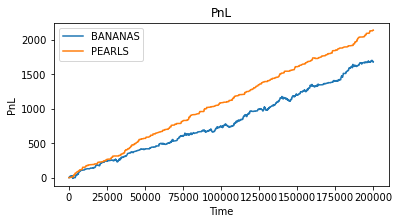

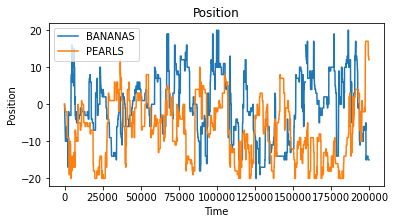

In [480]:
plot_pnl(results)
plot_position(dfs['positions'])

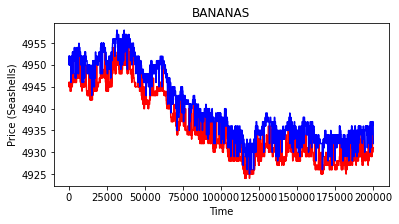

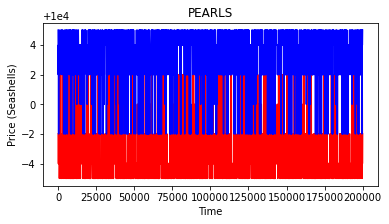

In [481]:
for s in symbols:
    plot_quote(dfs['quote'][s], s)
    # plot_price(markets[s], s, "mid_px_mavg10")

# Market Microstructure Analysis
- Spread Distribution
- Quote Size
- Notional
- Toxicity

In [423]:
def quote_weighted_px_full(quote, levels=5):
    notional = quote.bid_sz*quote.bid + quote.ask_sz*quote.ask
    size = quote.bid_sz + quote.ask_sz
    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size

def quote_squared_weighted_px_full(quote, levels=5):
    # Weighted average price, weight is the size of the quote squared
    notional = np.square(quote.bid_sz)*quote.bid + np.square(quote.ask_sz)*quote.ask
    size_squared = np.square(quote.bid_sz) + np.square(quote.ask_sz)
    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*np.square(quote[f'bid_sz_{i}'])
        size_squared += np.square(quote[f'bid_sz_{i}'])
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*np.square(quote[f'ask_sz_{i}'])
        size_squared += np.square(quote[f'ask_sz_{i}'])
    
    return notional/size_squared

def md_preprocess(md):
    """ Pre-computing additional columns for analyzing quote
    """
    # md['mid_price'] = (md.ask_price_1 + md.bid_price_1)/2
    md['spread'] = md.ask - md.bid
    md['return'] = md['mid_price']/md['mid_price'].iloc[0] # % change in price since the beginning
    
    for t in [5, 10, 25, 50, 100]:
        md[f'mid_px_mavg{t}'] = md['mid_price'].rolling(t, min_periods=0).mean()
        md[f'mid_px_mavg{t}_norm'] = md[f'mid_px_mavg{t}']/md['mid_price']
        md[f'px_norm_mavg{t}'] = md['return'].rolling(t, min_periods=0).mean()
        
        
    # quote weighted average price
    quote_sz = md.bid_sz + md.ask_sz
    md['quote_wgt_px_top'] = (md.bid_sz*md.bid + md.ask_sz*md.ask)/quote_sz
    md['fair_v1'] = md.apply(quote_weighted_px_full, axis=1)
    md['fair_v2'] = md.apply(quote_squared_weighted_px_full, axis=1)
    
    for t in [1, 5, 10, 20, 30, 50, 100]:
        # Price move since the past
        md[f'px_move_{t}'] = md.mid_price-md.mid_price.shift(t)
        md[f'px_move_{t}'].fillna(0, inplace=True)
        md[f'px_move_{t}_norm'] = md[f'px_move_{t}']/md['mid_price']
        
        # log return
        md[f'log_return_{t}'] = np.log(md.mid_price)-np.log(md.mid_price.shift(t))
        md[f'log_return_{t}'].fillna(1, inplace=True)
    # Volume    
    for t in [5, 10, 20, 30, 50]:
        md[f'volume_{t}'] = md['volume'].rolling(t, min_periods=0).sum()
        
    md = md.copy()

    md['quote_imb'] = md.bid_sz/quote_sz
    md['levels_imb'] = md.bid_levels-md.ask_levels # Positive implies people are preparing for quote to move in
    md['vol_imb'] = (md.buy_vol/(md.buy_vol+md.sell_vol)).fillna(0.5)
    
    ############# Future
    # Future prices
    for t in [1, 5, 10, 20, 30, 50, 100]:
        # Future - present
        # Mid to mid, bid to mid, ask to mid
        md[f'fpx_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.mid_price
        md[f'fpx_bid_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.bid
        md[f'fpx_ask_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.ask
    for t in [1, 5, 10, 20, 30, 50, 100]:
        md[f'fpx_move_{t}'] = np.sign(md[f'fpx_{t}'])
        md[f'fpx_bid_move_{t}'] = md[f'fpx_bid_{t}'] > 0
        md[f'fpx_ask_move_{t}'] = md[f'fpx_ask_{t}'] <= 0
    md['fvolume'] = md['volume'].shift(-1)
    for t in [5, 10, 20, 30, 50]:
        md[f'fvolume_{t}'] = md[f'volume_{t}'].shift(-t)
    md = md.copy()
        
    # Features
    md['bid_sz_mavg'] = md['bid_sz'].cumsum()/(1+md['timestamp']/100)
    md['ask_sz_mavg'] = md['ask_sz'].cumsum()/(1+md['timestamp']/100)
       
    for v in [1, 2]:
        md[f'dist_fair_v{v}'] = md[f'fair_v{v}']-md['mid_price']
        md[f'dist_fair_v{v}_norm'] = md[f'dist_fair_v{v}']/md['mid_price']
        
        md[f'dist_fair_v{v}_bid'] = md[f'fair_v{v}']-md['bid'] # expected to be positive
        md[f'dist_fair_v{v}_ask'] = md[f'fair_v{v}']-md['ask'] # expected to be negative
    
    md['bid_improve'] = md['bid'] > md['bid'].shift(1)
    md['bid_revert'] = md['bid'] < md['bid'].shift(1)

    md['ask_improve'] = md['ask'] < md['ask'].shift(1)
    md['ask_revert'] = md['ask'] > md['ask'].shift(1)
    
    return md

def high_level_summary(sym, quote):
    print(sym)
    summary = quote.agg({
        'spread':['mean','std'], 
        'mid_price': 'std', 
        'px_move_1':'mean',
        'volume':'sum',
        'trades':'sum',
        'bid_sz': 'mean', 
        'ask_sz':'mean', 
        'bid_sz_2': 'mean',
        'ask_sz_2': 'mean',
    })
    display(summary)

In [424]:
mid_labels = []
bid_labels = []
ask_labels = []
px_delta_cols = []

for t in [1, 5, 10, 20, 30, 50, 100]:
    px_delta_cols.append(f'fpx_{t}')
    mid_labels.append(f'fpx_move_{t}')
    bid_labels.append(f'fpx_bid_move_{t}')
    ask_labels.append(f'fpx_ask_move_{t}')

In [425]:
hist_returns = []
log_returns = []
for t in [1, 5, 10, 20, 30, 50, 100]:
    hist_returns.append(f'px_move_{t}_norm')
    log_returns.append(f'log_return_{t}')
    
mavg_cols = []
for t in [5, 10, 25, 50, 100]:
    mavg_cols.append(f'mid_px_mavg{t}_norm')

## Bananas

In [426]:
sym = symbols[0]
print(sym)
quote = dfs['order_depths'][sym].copy()
quote = md_preprocess(quote)

BANANAS


In [326]:
high_level_summary(sym, quote)

BANANAS


,spread,mid_price,px_move_1,volume,trades,bid_sz,ask_sz,bid_sz_2,ask_sz_2
mean,5.307808,NaN,-0.008759,NaN,NaN,17.561061,17.779279,23.059946,21.993046
std,1.898224,7.959668,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,1270.0,506.0,NaN,NaN,NaN,NaN


### Orderbook Analysis

In [19]:
pd.merge(left = quote.groupby('bid_levels').size().rename('counts_bid'), 
         right = quote.groupby('ask_levels').size().rename('counts_ask'), 
         left_index=True, right_index=True)

,counts_bid,counts_ask
bid_levels,,
1,527,544
2,1140,1097
3,304,331
4,25,23
5,1,2


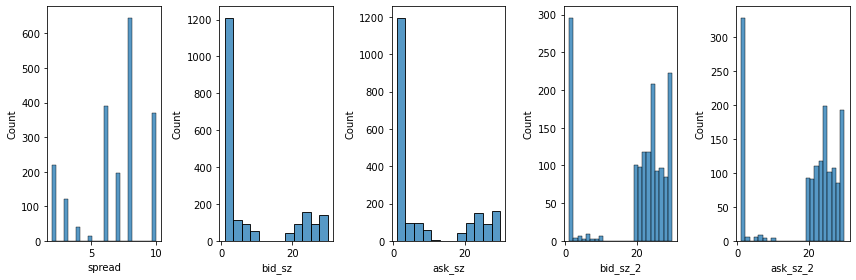

In [21]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['spread','bid_sz','ask_sz', 'bid_sz_2','ask_sz_2']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

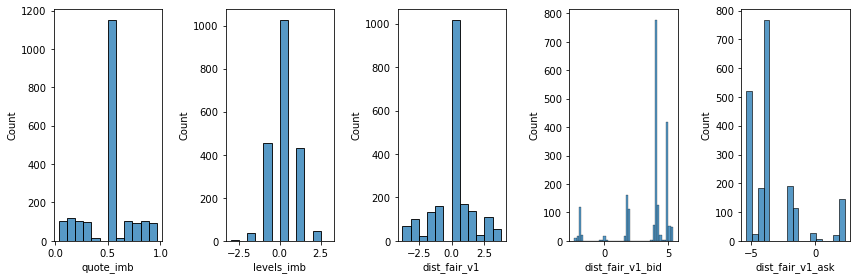

In [266]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['quote_imb','levels_imb', 'dist_fair_v1','dist_fair_v1_bid','dist_fair_v1_ask']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

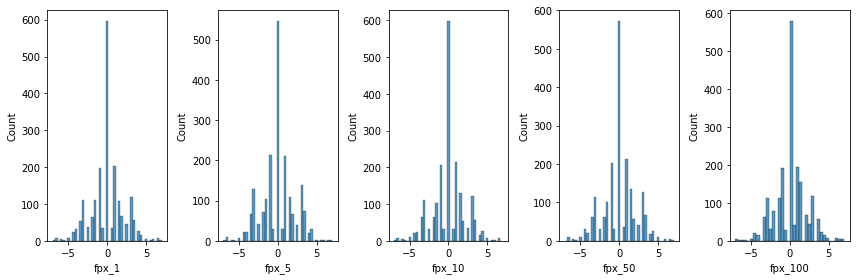

In [23]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['fpx_1','fpx_5','fpx_10','fpx_50','fpx_100']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

In [267]:
# sub_data = quote.loc[np.abs(quote.dist_fair_full) > 1].copy()
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_v1', 'dist_fair_v2'] + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1998 1998 100.00%


,quote_imb,levels_imb,dist_fair_v1,dist_fair_v2,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_20,fpx_move_30,fpx_move_50,fpx_move_100,fpx_move_200
quote_imb,1.000,-0.068,0.223,0.235,0.091,0.089,0.126,0.080,0.085,0.117,0.117,0.126
levels_imb,-0.068,1.000,-0.924,-0.907,-0.614,-0.613,-0.600,-0.627,-0.627,-0.603,-0.581,-0.563
dist_fair_v1,0.223,-0.924,1.000,0.999,0.614,0.622,0.606,0.627,0.627,0.609,0.595,0.589
dist_fair_v2,0.235,-0.907,0.999,1.000,0.607,0.616,0.600,0.619,0.621,0.604,0.590,0.587
fpx_move_1,0.091,-0.614,0.614,0.607,1.000,0.413,0.392,0.433,0.442,0.404,0.381,0.375
fpx_move_5,0.089,-0.613,0.622,0.616,0.413,1.000,0.374,0.423,0.425,0.398,0.375,0.352
fpx_move_10,0.126,-0.600,0.606,0.600,0.392,0.374,1.000,0.424,0.400,0.383,0.366,0.384
fpx_move_20,0.080,-0.627,0.627,0.619,0.433,0.423,0.424,1.000,0.439,0.403,0.404,0.385
fpx_move_30,0.085,-0.627,0.627,0.621,0.442,0.425,0.400,0.439,1.000,0.406,0.411,0.410
fpx_move_50,0.117,-0.603,0.609,0.604,0.404,0.398,0.383,0.403,0.406,1.000,0.409,0.422


In [270]:
sub_data = quote.loc[np.abs(quote.volume) > 0].copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_v1', 'bid_improve','bid_revert','ask_improve','ask_revert'] + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1998 394 19.72%


,quote_imb,levels_imb,dist_fair_v1,bid_improve,bid_revert,ask_improve,ask_revert,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_20,fpx_move_30,fpx_move_50,fpx_move_100,fpx_move_200
quote_imb,1.000,0.006,0.179,-0.089,0.131,0.028,-0.149,0.030,0.114,0.109,0.065,0.072,0.125,0.066,0.082
levels_imb,0.006,1.000,-0.920,0.520,-0.371,-0.507,0.371,-0.659,-0.625,-0.629,-0.662,-0.636,-0.622,-0.602,-0.613
dist_fair_v1,0.179,-0.920,1.000,-0.482,0.363,0.480,-0.391,0.662,0.647,0.637,0.667,0.647,0.620,0.620,0.631
bid_improve,-0.089,0.520,-0.482,1.000,-0.559,-0.173,0.232,-0.380,-0.372,-0.331,-0.303,-0.366,-0.441,-0.326,-0.312
bid_revert,0.131,-0.371,0.363,-0.559,1.000,0.285,-0.160,0.330,0.269,0.208,0.262,0.265,0.306,0.235,0.246
ask_improve,0.028,-0.507,0.480,-0.173,0.285,1.000,-0.560,0.381,0.324,0.339,0.346,0.353,0.345,0.307,0.312
ask_revert,-0.149,0.371,-0.391,0.232,-0.160,-0.560,1.000,-0.270,-0.270,-0.252,-0.217,-0.245,-0.294,-0.228,-0.290
fpx_move_1,0.030,-0.659,0.662,-0.380,0.330,0.381,-0.270,1.000,0.449,0.450,0.456,0.576,0.460,0.377,0.401
fpx_move_5,0.114,-0.625,0.647,-0.372,0.269,0.324,-0.270,0.449,1.000,0.358,0.427,0.448,0.462,0.433,0.410
fpx_move_10,0.109,-0.629,0.637,-0.331,0.208,0.339,-0.252,0.450,0.358,1.000,0.503,0.424,0.366,0.393,0.417


In [26]:
# Very little correlation between spread and past volume
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['spread', 'fvolume', 'fvolume_5', 'fvolume_10', 'fvolume_20',
       'fvolume_30', 'fvolume_50']].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1997 1997 100.00%


,spread,fvolume,fvolume_5,fvolume_10,fvolume_20,fvolume_30,fvolume_50
spread,1.000,-0.115,-0.059,-0.050,-0.026,0.006,-0.013
fvolume,-0.115,1.000,0.456,0.328,0.238,0.178,0.177
fvolume_5,-0.059,0.456,1.000,0.719,0.525,0.402,0.386
fvolume_10,-0.050,0.328,0.719,1.000,0.730,0.575,0.528
fvolume_20,-0.026,0.238,0.525,0.730,1.000,0.828,0.690
fvolume_30,0.006,0.178,0.402,0.575,0.828,1.000,0.805
fvolume_50,-0.013,0.177,0.386,0.528,0.690,0.805,1.000


In [336]:
# Past price move vs future price move
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[log_returns + hist_returns + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1998 1998 100.00%


,log_return_1,log_return_5,log_return_10,log_return_20,log_return_30,log_return_50,log_return_100,px_move_1_norm,px_move_5_norm,px_move_10_norm,px_move_20_norm,px_move_30_norm,px_move_50_norm,px_move_100_norm,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_20,fpx_move_30,fpx_move_50,fpx_move_100
log_return_1,1.000,0.447,0.315,0.223,0.181,0.140,0.097,0.015,0.008,0.007,0.007,0.008,0.008,0.009,-0.031,-0.028,-0.027,-0.026,0.021,0.023,0.002
log_return_5,0.447,1.000,0.706,0.498,0.406,0.313,0.218,0.004,0.008,0.006,0.007,0.008,0.010,0.015,0.009,-0.012,-0.043,0.033,0.055,0.047,0.031
log_return_10,0.315,0.706,1.000,0.705,0.575,0.443,0.309,-0.006,-0.003,0.008,0.008,0.010,0.013,0.020,-0.009,-0.030,-0.014,0.048,0.071,0.075,0.045
log_return_20,0.223,0.498,0.705,1.000,0.815,0.628,0.438,0.001,0.006,-0.005,0.011,0.013,0.017,0.027,-0.012,0.006,0.034,0.079,0.081,0.096,0.053
log_return_30,0.181,0.406,0.575,0.815,1.000,0.771,0.538,0.003,0.020,0.032,0.034,0.016,0.021,0.033,0.009,0.015,0.047,0.059,0.096,0.097,0.009
log_return_50,0.140,0.313,0.443,0.628,0.771,1.000,0.698,0.002,0.012,0.021,0.053,0.055,0.027,0.042,0.011,0.013,0.049,0.074,0.113,0.043,-0.044
log_return_100,0.097,0.218,0.309,0.438,0.538,0.698,1.000,0.001,0.002,0.007,0.017,0.031,0.058,0.060,0.009,0.010,0.034,0.032,0.021,-0.039,-0.062
px_move_1_norm,0.015,0.004,-0.006,0.001,0.003,0.002,0.001,1.000,0.494,0.437,0.378,0.355,0.302,0.255,-0.361,-0.320,-0.287,-0.274,-0.264,-0.228,-0.180
px_move_5_norm,0.008,0.008,-0.003,0.006,0.020,0.012,0.002,0.494,1.000,0.549,0.460,0.426,0.364,0.279,-0.321,-0.307,-0.281,-0.282,-0.237,-0.217,-0.178
px_move_10_norm,0.007,0.006,0.008,-0.005,0.032,0.021,0.007,0.437,0.549,1.000,0.557,0.503,0.429,0.336,-0.296,-0.288,-0.277,-0.255,-0.239,-0.229,-0.180


In [427]:
# Past price move vs future price move
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[mavg_cols + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1997 1997 100.00%


,mid_px_mavg5_norm,mid_px_mavg10_norm,mid_px_mavg25_norm,mid_px_mavg50_norm,mid_px_mavg100_norm,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_20,fpx_move_30,fpx_move_50,fpx_move_100
mid_px_mavg5_norm,1.000,0.921,0.786,0.673,0.553,0.455,0.396,0.344,0.349,0.320,0.294,0.243
mid_px_mavg10_norm,0.921,1.000,0.896,0.774,0.637,0.444,0.399,0.360,0.354,0.327,0.304,0.243
mid_px_mavg25_norm,0.786,0.896,1.000,0.925,0.780,0.401,0.375,0.362,0.336,0.318,0.307,0.241
mid_px_mavg50_norm,0.673,0.774,0.925,1.000,0.913,0.349,0.323,0.327,0.301,0.282,0.289,0.237
mid_px_mavg100_norm,0.553,0.637,0.780,0.913,1.000,0.300,0.272,0.282,0.256,0.245,0.269,0.224
fpx_move_1,0.455,0.444,0.401,0.349,0.300,1.000,0.386,0.314,0.274,0.253,0.208,0.168
fpx_move_5,0.396,0.399,0.375,0.323,0.272,0.386,1.000,0.423,0.345,0.286,0.240,0.184
fpx_move_10,0.344,0.360,0.362,0.327,0.282,0.314,0.423,1.000,0.432,0.393,0.315,0.249
fpx_move_20,0.349,0.354,0.336,0.301,0.256,0.274,0.345,0.432,1.000,0.490,0.393,0.287
fpx_move_30,0.320,0.327,0.318,0.282,0.245,0.253,0.286,0.393,0.490,1.000,0.526,0.343


### Quote Change Analysis

In [27]:
quote_cols = ['bid_levels','ask_levels','levels_imb', 'bid_sz','ask_sz', 'bid_sz_2','ask_sz_2',
              'dist_fair_bid','dist_fair_ask', 'volume']

In [28]:
quote[quote_cols+px_delta_cols[:3]].describe().round(2)

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,bid_sz_2,ask_sz_2,dist_fair_bid,dist_fair_ask,volume,fpx_1,fpx_5,fpx_10
count,1997.00,1997.00,1997.00,1997.00,1997.00,1470.00,1453.00,1997.00,1997.00,1997.00,1997.00,1997.00,1997.00
mean,1.91,1.92,-0.00,8.35,8.63,19.82,19.29,3.42,-3.40,0.37,0.00,0.00,0.01
std,0.68,0.70,0.79,10.26,10.41,10.02,10.33,1.95,1.96,1.20,2.12,2.13,2.09
min,1.00,1.00,-3.00,1.00,1.00,1.00,1.00,-2.34,-5.40,0.00,-7.00,-7.00,-7.00
25%,1.00,1.00,0.00,1.00,1.00,20.00,20.00,3.84,-4.96,0.00,-1.00,-1.00,-1.00
50%,2.00,2.00,0.00,2.00,2.00,23.00,23.00,4.00,-4.00,0.00,0.00,0.00,0.00
75%,2.00,2.00,0.00,20.00,21.00,27.00,27.00,4.96,-1.97,0.00,1.00,1.00,1.00
max,5.00,5.00,3.00,30.00,30.00,30.00,30.00,5.36,2.29,13.00,7.00,7.00,7.00


In [29]:
quote.loc[quote.bid_improve][quote_cols+px_delta_cols].describe().round(2)

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,bid_sz_2,ask_sz_2,dist_fair_bid,dist_fair_ask,volume,fpx_1,fpx_5,fpx_10,fpx_20,fpx_30,fpx_50,fpx_100,fpx_200
count,674.00,674.00,674.00,674.00,674.00,674.00,529.00,674.00,674.00,674.00,674.00,674.00,674.00,674.00,674.00,674.00,674.00,674.00
mean,2.44,1.95,0.50,3.04,6.95,15.78,20.47,1.80,-3.72,0.39,-0.93,-0.96,-0.91,-0.85,-0.91,-1.02,-0.81,-0.90
std,0.57,0.63,0.84,2.60,9.61,11.59,9.68,2.31,1.60,1.27,2.25,2.20,2.20,2.29,2.31,2.20,2.14,2.19
min,2.00,1.00,-2.00,1.00,1.00,1.00,1.00,-2.34,-5.40,0.00,-7.00,-7.00,-7.00,-6.50,-7.00,-7.00,-7.00,-7.00
25%,2.00,2.00,0.00,1.00,1.00,2.00,20.00,0.00,-4.27,0.00,-2.50,-2.50,-2.50,-2.50,-2.50,-3.00,-2.00,-2.50
50%,2.00,2.00,1.00,2.00,2.00,21.00,24.00,1.89,-4.00,0.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
75%,3.00,2.00,1.00,4.00,7.00,26.00,27.00,4.00,-3.96,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.38,0.50
max,5.00,4.00,3.00,12.00,30.00,30.00,30.00,4.33,2.16,13.00,6.00,4.50,6.50,6.00,6.50,6.50,6.50,6.50


In [30]:
quote.loc[quote.bid_revert][quote_cols+px_delta_cols].describe().round(2)

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,bid_sz_2,ask_sz_2,dist_fair_bid,dist_fair_ask,volume,fpx_1,fpx_5,fpx_10,fpx_20,fpx_30,fpx_50,fpx_100,fpx_200
count,677.00,677.00,677.00,677.00,677.00,268.00,382.00,677.00,677.00,677.00,677.00,677.00,677.00,677.00,677.00,677.00,677.00,677.00
mean,1.43,1.73,-0.30,15.89,12.75,23.18,18.55,4.54,-3.29,0.40,0.61,0.56,0.61,0.54,0.61,0.65,0.70,0.76
std,0.55,0.73,0.57,11.67,11.44,7.03,10.61,0.75,2.25,1.17,1.86,1.90,1.89,1.92,1.85,1.86,1.87,1.80
min,1.00,1.00,-2.00,1.00,1.00,1.00,1.00,0.00,-5.37,0.00,-5.00,-4.50,-5.00,-4.50,-5.00,-4.00,-3.50,-3.50
25%,1.00,1.00,-1.00,2.00,2.00,22.00,2.25,4.00,-5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,2.00,0.00,22.00,7.00,24.00,23.00,5.00,-4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2.00,2.00,0.00,26.00,24.00,27.25,26.00,5.00,-1.86,0.00,1.50,1.50,1.50,1.50,1.50,1.50,1.50,1.50
max,3.00,4.00,1.00,30.00,30.00,30.00,30.00,5.36,2.29,12.00,7.00,7.00,7.00,7.00,6.00,7.00,7.00,7.00


## Pearls

In [337]:
sym = symbols[1]
print(sym)
quote = dfs['order_depths'][sym].copy()
quote = md_preprocess(quote)

PEARLS


In [32]:
print(quote.columns)

Index(['timestamp', 'symbol', 'bid_levels', 'bid', 'bid_sz', 'bid_2',
       'bid_sz_2', 'bid_5', 'bid_sz_5', 'bid_4',
       ...
       'bid_sz_mavg', 'ask_sz_mavg', 'dist_fair_full', 'dist_fair_3',
       'dist_fair_bid', 'dist_fair_ask', 'bid_improve', 'bid_revert',
       'ask_improve', 'ask_revert'],
      dtype='object', length=136)


In [33]:
high_level_summary(sym, quote)

PEARLS


,spread,mid_price,px_move_1,volume,trades,bid_sz,ask_sz,bid_sz_2,ask_sz_2
mean,6.819730,NaN,0.0,NaN,NaN,8.350526,8.625939,19.819728,19.293187
std,2.467332,1.4925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,NaN,739.0,391.0,NaN,NaN,NaN,NaN


### Orderbook Analysis

In [34]:
pd.merge(left = quote.groupby('bid_levels').size().rename('counts_bid'), 
         right = quote.groupby('ask_levels').size().rename('counts_ask'), 
         left_index=True, right_index=True)

,counts_bid,counts_ask
bid_levels,,
1,527,544
2,1140,1097
3,304,331
4,25,23
5,1,2


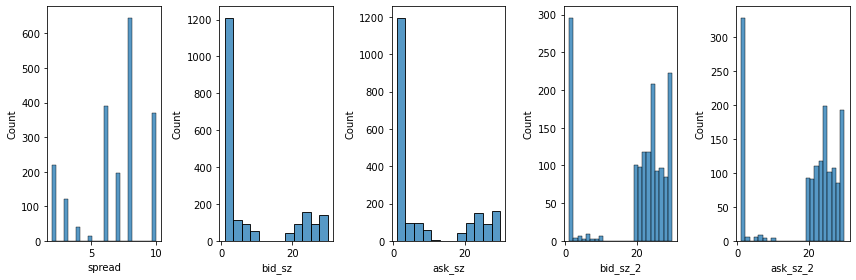

In [35]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['spread','bid_sz','ask_sz', 'bid_sz_2','ask_sz_2']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

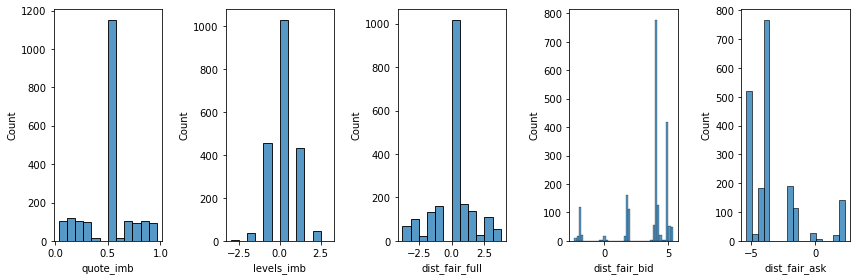

In [36]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['quote_imb','levels_imb', 'dist_fair_full','dist_fair_bid','dist_fair_ask']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

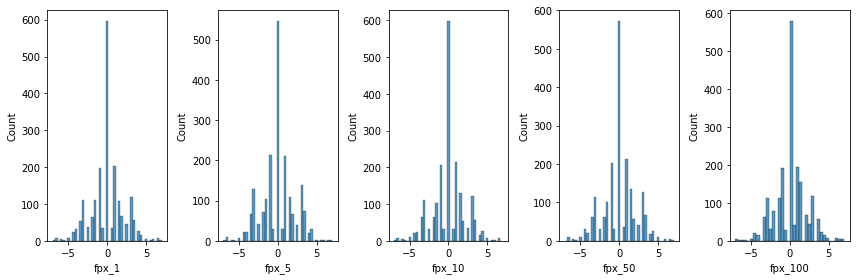

In [37]:
f, ax = plt.subplots(1, 5, figsize=(12,4))
for i, col in enumerate(['fpx_1','fpx_5','fpx_10','fpx_50','fpx_100']):
    sns.histplot(x=col, data=quote, ax=ax[i])
plt.tight_layout()

In [38]:
# sub_data = quote.loc[np.abs(quote.dist_fair_full) > 1].copy()
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_full', 'dist_fair_3'] + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1997 1997 100.00%


,quote_imb,levels_imb,dist_fair_full,dist_fair_3,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_20,fpx_move_30,fpx_move_50,fpx_move_100,fpx_move_200
quote_imb,1.000,-0.068,0.223,0.251,0.091,0.089,0.130,0.082,0.081,0.122,0.122,0.129
levels_imb,-0.068,1.000,-0.924,-0.807,-0.614,-0.615,-0.602,-0.624,-0.627,-0.606,-0.575,-0.568
dist_fair_full,0.223,-0.924,1.000,0.931,0.613,0.624,0.609,0.624,0.629,0.616,0.589,0.590
dist_fair_3,0.251,-0.807,0.931,1.000,0.578,0.586,0.574,0.589,0.592,0.582,0.559,0.556
fpx_move_1,0.091,-0.614,0.613,0.578,1.000,0.415,0.396,0.430,0.438,0.415,0.384,0.377
fpx_move_5,0.089,-0.615,0.624,0.586,0.415,1.000,0.380,0.422,0.426,0.396,0.367,0.375
fpx_move_10,0.130,-0.602,0.609,0.574,0.396,0.380,1.000,0.426,0.407,0.391,0.383,0.398
fpx_move_20,0.082,-0.624,0.624,0.589,0.430,0.422,0.426,1.000,0.443,0.393,0.407,0.395
fpx_move_30,0.081,-0.627,0.629,0.592,0.438,0.426,0.407,0.443,1.000,0.410,0.392,0.406
fpx_move_50,0.122,-0.606,0.616,0.582,0.415,0.396,0.391,0.393,0.410,1.000,0.413,0.415


In [39]:
sub_data = quote.loc[np.abs(quote.volume) > 2].copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['quote_imb', 'levels_imb', 'dist_fair_full', 'dist_fair_3'] + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1997 69 3.46%


,quote_imb,levels_imb,dist_fair_full,dist_fair_3,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_20,fpx_move_30,fpx_move_50,fpx_move_100,fpx_move_200
quote_imb,1.000,-0.005,0.287,0.295,0.082,0.173,0.152,0.074,0.050,0.144,0.168,0.214
levels_imb,-0.005,1.000,-0.907,-0.854,-0.687,-0.648,-0.686,-0.782,-0.729,-0.589,-0.627,-0.616
dist_fair_full,0.287,-0.907,1.000,0.969,0.699,0.674,0.694,0.753,0.702,0.631,0.674,0.633
dist_fair_3,0.295,-0.854,0.969,1.000,0.682,0.654,0.676,0.737,0.678,0.606,0.694,0.612
fpx_move_1,0.082,-0.687,0.699,0.682,1.000,0.468,0.507,0.584,0.571,0.510,0.487,0.414
fpx_move_5,0.173,-0.648,0.674,0.654,0.468,1.000,0.468,0.510,0.450,0.463,0.510,0.441
fpx_move_10,0.152,-0.686,0.694,0.676,0.507,0.468,1.000,0.587,0.476,0.524,0.549,0.515
fpx_move_20,0.074,-0.782,0.753,0.737,0.584,0.510,0.587,1.000,0.568,0.390,0.580,0.474
fpx_move_30,0.050,-0.729,0.702,0.678,0.571,0.450,0.476,0.568,1.000,0.454,0.483,0.456
fpx_move_50,0.144,-0.589,0.631,0.606,0.510,0.463,0.524,0.390,0.454,1.000,0.570,0.592


In [40]:
# Very little correlation between spread and past volume
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[['spread', 'fvolume', 'fvolume_5', 'fvolume_10', 'fvolume_20',
       'fvolume_30', 'fvolume_50']].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1997 1997 100.00%


,spread,fvolume,fvolume_5,fvolume_10,fvolume_20,fvolume_30,fvolume_50
spread,1.000,-0.115,-0.059,-0.050,-0.026,0.006,-0.013
fvolume,-0.115,1.000,0.456,0.328,0.238,0.178,0.177
fvolume_5,-0.059,0.456,1.000,0.719,0.525,0.402,0.386
fvolume_10,-0.050,0.328,0.719,1.000,0.730,0.575,0.528
fvolume_20,-0.026,0.238,0.525,0.730,1.000,0.828,0.690
fvolume_30,0.006,0.178,0.402,0.575,0.828,1.000,0.805
fvolume_50,-0.013,0.177,0.386,0.528,0.690,0.805,1.000


In [338]:
# Past price move vs future price move
sub_data = quote.copy()
print("{} {} {:.2f}%".format(len(quote), len(sub_data), 100*len(sub_data)/len(quote)))
corr = sub_data[log_returns + hist_returns + mid_labels].corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

1998 1998 100.00%


,log_return_1,log_return_5,log_return_10,log_return_20,log_return_30,log_return_50,log_return_100,px_move_1_norm,px_move_5_norm,px_move_10_norm,px_move_20_norm,px_move_30_norm,px_move_50_norm,px_move_100_norm,fpx_move_1,fpx_move_5,fpx_move_10,fpx_move_20,fpx_move_30,fpx_move_50,fpx_move_100
log_return_1,1.000,0.447,0.315,0.223,0.181,0.140,0.097,0.009,0.005,0.005,0.005,0.005,0.005,0.005,-0.031,0.022,-0.031,-0.031,-0.032,-0.031,-0.031
log_return_5,0.447,1.000,0.706,0.498,0.406,0.313,0.218,-0.000,0.004,0.002,0.002,0.002,0.002,0.002,0.010,0.021,0.009,0.010,-0.015,-0.003,-0.004
log_return_10,0.315,0.706,1.000,0.705,0.574,0.443,0.309,-0.004,0.018,0.003,0.002,0.002,0.001,0.002,-0.002,0.007,0.006,0.015,-0.020,0.005,-0.012
log_return_20,0.223,0.498,0.705,1.000,0.814,0.628,0.438,-0.002,0.012,0.006,0.002,0.001,0.001,0.002,-0.007,0.004,0.009,-0.001,-0.021,-0.004,-0.011
log_return_30,0.181,0.406,0.574,0.814,1.000,0.771,0.538,0.004,0.014,0.008,0.008,0.002,0.001,0.001,0.008,0.008,-0.013,-0.001,-0.009,-0.015,-0.020
log_return_50,0.140,0.313,0.443,0.628,0.771,1.000,0.698,-0.007,0.004,-0.002,-0.012,-0.012,0.001,0.001,0.010,0.010,0.016,0.025,-0.012,0.002,-0.014
log_return_100,0.097,0.218,0.309,0.438,0.538,0.698,1.000,-0.001,0.003,-0.004,-0.009,-0.012,0.005,0.002,0.006,0.009,0.001,0.017,-0.009,0.003,-0.028
px_move_1_norm,0.009,-0.000,-0.004,-0.002,0.004,-0.007,-0.001,1.000,0.492,0.497,0.524,0.520,0.496,0.473,-0.435,-0.437,-0.424,-0.419,-0.459,-0.437,-0.429
px_move_5_norm,0.005,0.004,0.018,0.012,0.014,0.004,0.003,0.492,1.000,0.490,0.520,0.516,0.496,0.459,-0.425,-0.442,-0.433,-0.440,-0.437,-0.413,-0.418
px_move_10_norm,0.005,0.002,0.003,0.006,0.008,-0.002,-0.004,0.497,0.490,1.000,0.515,0.474,0.463,0.457,-0.422,-0.427,-0.392,-0.437,-0.399,-0.425,-0.389


### Quote Change Analysis
- What happens to the quote when price improves?
- What happens to the quote when a level is taken out?

In [41]:
quote_cols = ['bid_levels','ask_levels','levels_imb', 'bid_sz','ask_sz', 'bid_sz_2','ask_sz_2',
              'dist_fair_bid','dist_fair_ask', 'volume']

In [42]:
quote[quote_cols+px_delta_cols[:3]].describe().round(2)

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,bid_sz_2,ask_sz_2,dist_fair_bid,dist_fair_ask,volume,fpx_1,fpx_5,fpx_10
count,1997.00,1997.00,1997.00,1997.00,1997.00,1470.00,1453.00,1997.00,1997.00,1997.00,1997.00,1997.00,1997.00
mean,1.91,1.92,-0.00,8.35,8.63,19.82,19.29,3.42,-3.40,0.37,0.00,0.00,0.01
std,0.68,0.70,0.79,10.26,10.41,10.02,10.33,1.95,1.96,1.20,2.12,2.13,2.09
min,1.00,1.00,-3.00,1.00,1.00,1.00,1.00,-2.34,-5.40,0.00,-7.00,-7.00,-7.00
25%,1.00,1.00,0.00,1.00,1.00,20.00,20.00,3.84,-4.96,0.00,-1.00,-1.00,-1.00
50%,2.00,2.00,0.00,2.00,2.00,23.00,23.00,4.00,-4.00,0.00,0.00,0.00,0.00
75%,2.00,2.00,0.00,20.00,21.00,27.00,27.00,4.96,-1.97,0.00,1.00,1.00,1.00
max,5.00,5.00,3.00,30.00,30.00,30.00,30.00,5.36,2.29,13.00,7.00,7.00,7.00


In [43]:
quote.loc[quote.bid_improve][quote_cols+px_delta_cols].describe().round(2)

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,bid_sz_2,ask_sz_2,dist_fair_bid,dist_fair_ask,volume,fpx_1,fpx_5,fpx_10,fpx_20,fpx_30,fpx_50,fpx_100,fpx_200
count,674.00,674.00,674.00,674.00,674.00,674.00,529.00,674.00,674.00,674.00,674.00,674.00,674.00,674.00,674.00,674.00,674.00,674.00
mean,2.44,1.95,0.50,3.04,6.95,15.78,20.47,1.80,-3.72,0.39,-0.93,-0.96,-0.91,-0.85,-0.91,-1.02,-0.81,-0.90
std,0.57,0.63,0.84,2.60,9.61,11.59,9.68,2.31,1.60,1.27,2.25,2.20,2.20,2.29,2.31,2.20,2.14,2.19
min,2.00,1.00,-2.00,1.00,1.00,1.00,1.00,-2.34,-5.40,0.00,-7.00,-7.00,-7.00,-6.50,-7.00,-7.00,-7.00,-7.00
25%,2.00,2.00,0.00,1.00,1.00,2.00,20.00,0.00,-4.27,0.00,-2.50,-2.50,-2.50,-2.50,-2.50,-3.00,-2.00,-2.50
50%,2.00,2.00,1.00,2.00,2.00,21.00,24.00,1.89,-4.00,0.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
75%,3.00,2.00,1.00,4.00,7.00,26.00,27.00,4.00,-3.96,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.38,0.50
max,5.00,4.00,3.00,12.00,30.00,30.00,30.00,4.33,2.16,13.00,6.00,4.50,6.50,6.00,6.50,6.50,6.50,6.50


In [44]:
quote.loc[quote.bid_revert][quote_cols+px_delta_cols].describe().round(2)

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,bid_sz_2,ask_sz_2,dist_fair_bid,dist_fair_ask,volume,fpx_1,fpx_5,fpx_10,fpx_20,fpx_30,fpx_50,fpx_100,fpx_200
count,677.00,677.00,677.00,677.00,677.00,268.00,382.00,677.00,677.00,677.00,677.00,677.00,677.00,677.00,677.00,677.00,677.00,677.00
mean,1.43,1.73,-0.30,15.89,12.75,23.18,18.55,4.54,-3.29,0.40,0.61,0.56,0.61,0.54,0.61,0.65,0.70,0.76
std,0.55,0.73,0.57,11.67,11.44,7.03,10.61,0.75,2.25,1.17,1.86,1.90,1.89,1.92,1.85,1.86,1.87,1.80
min,1.00,1.00,-2.00,1.00,1.00,1.00,1.00,0.00,-5.37,0.00,-5.00,-4.50,-5.00,-4.50,-5.00,-4.00,-3.50,-3.50
25%,1.00,1.00,-1.00,2.00,2.00,22.00,2.25,4.00,-5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,2.00,0.00,22.00,7.00,24.00,23.00,5.00,-4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2.00,2.00,0.00,26.00,24.00,27.25,26.00,5.00,-1.86,0.00,1.50,1.50,1.50,1.50,1.50,1.50,1.50,1.50
max,3.00,4.00,1.00,30.00,30.00,30.00,30.00,5.36,2.29,12.00,7.00,7.00,7.00,7.00,6.00,7.00,7.00,7.00


## Pearls Price Cross Analysis
- What does the quote look like when bid/ask cross 10K?

In [45]:
sym = symbols[1]
print(sym)
quote = dfs['order_depths'][sym].copy()
md_preprocess(quote)

PEARLS


In [46]:
bid_cross = quote.loc[quote.bid >= 10000].copy()
ask_cross = quote.loc[quote.ask <= 10000].copy()

In [47]:
quote[['bid_levels','ask_levels','levels_imb', 'bid_sz','ask_sz', 'dist_fair_bid','dist_fair_ask']].describe()

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,dist_fair_bid,dist_fair_ask
count,1997.000000,1997.000000,1997.000000,1997.000000,1997.000000,1997.000000,1997.000000
mean,1.914872,1.919379,-0.004507,8.350526,8.625939,3.416126,-3.403603
std,0.680949,0.697842,0.785311,10.259866,10.413341,1.953155,1.961953
min,1.000000,1.000000,-3.000000,1.000000,1.000000,-2.339623,-5.400000
25%,1.000000,1.000000,0.000000,1.000000,1.000000,3.836066,-4.964912
50%,2.000000,2.000000,0.000000,2.000000,2.000000,4.000000,-4.000000
75%,2.000000,2.000000,0.000000,20.000000,21.000000,4.955556,-1.968254
max,5.000000,5.000000,3.000000,30.000000,30.000000,5.357143,2.285714


In [48]:
ask_cross[['bid_levels','ask_levels','levels_imb', 'bid_sz','ask_sz', 'dist_fair_bid','dist_fair_ask']].describe()

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,dist_fair_bid,dist_fair_ask
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,1.703518,2.869347,-1.165829,8.994975,2.638191,4.214927,1.601862
std,0.510038,0.638033,0.468867,10.927908,2.445311,0.639776,0.748758
min,1.000000,2.000000,-3.000000,1.000000,1.000000,1.750000,-0.250000
25%,1.000000,2.000000,-1.000000,1.000000,1.000000,3.953488,1.825324
50%,2.000000,3.000000,-1.000000,2.000000,1.000000,4.000000,1.953488
75%,2.000000,3.000000,-1.000000,21.500000,4.000000,4.911067,1.962950
max,3.000000,5.000000,0.000000,30.000000,13.000000,5.285714,2.285714


In [49]:
bid_cross[['bid_levels','ask_levels','levels_imb', 'bid_sz','ask_sz', 'dist_fair_bid','dist_fair_ask']].describe()

,bid_levels,ask_levels,levels_imb,bid_sz,ask_sz,dist_fair_bid,dist_fair_ask
count,195.000000,195.00000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,2.871795,1.65641,1.215385,2.815385,9.943590,-1.659793,-4.270050
std,0.633249,0.49731,0.470544,2.436147,11.360626,0.697459,0.617972
min,2.000000,1.00000,0.000000,1.000000,1.000000,-2.339623,-5.312500
25%,2.000000,1.00000,1.000000,1.000000,1.000000,-1.964912,-4.922619
50%,3.000000,2.00000,1.000000,1.000000,2.000000,-1.955556,-4.000000
75%,3.000000,2.00000,1.000000,4.000000,23.000000,-1.818182,-3.957447
max,5.000000,3.00000,3.000000,12.000000,30.000000,0.327273,-1.672727


# Regression

In [271]:
from sklearn.linear_model import LogisticRegression

In [475]:
sym = symbols[0]
print(sym)
quote = dfs['order_depths'][sym].copy()
quote = md_preprocess(quote)

BANANAS


In [476]:
features = ['dist_fair_v1', 'spread']
# ,'mid_px_mavg10_norm', 'bid_improve', 'ask_improve', 'bid_revert','ask_revert']

labels = []
for t in [1, 5, 10, 20, 30, 50, 100]:
    labels.append(f'fpx_move_{t}')

In [477]:
total_samples = len(quote)
train_samples = total_samples//4

train_data = quote.iloc[:train_samples][features+labels]
X_train = train_data[features].values
clfs = {}

for t in [1, 5, 10, 20, 30, 50, 100]:
    y_train = train_data[f'fpx_move_{t}'].values
    clfs[t] = LogisticRegression(random_state=0).fit(X_train, y_train)
    
for t in [1, 5, 10, 20, 30, 50, 100]:
    probs = clfs[t].predict_proba(X_train)
    train_data[f'predict_{t}'] = clfs[t].classes_[probs.argmax(axis=1)]
    train_data[f'predict_prob_{t}'] = probs.max(axis=1)
    train_data[f'correct_{t}'] = train_data[f'predict_{t}'] == train_data[f'fpx_move_{t}']
    print('{} {:.3}'.format(t, train_data[f'correct_{t}'].mean()))

1 0.591
5 0.599
10 0.607
20 0.625
30 0.565
50 0.561
100 0.525


In [432]:
clfs[10].coef_

array([[-5.79817161e-01,  1.47602657e-03],
       [ 3.48872714e-02, -4.72224482e-04],
       [ 5.44929890e-01, -1.00380208e-03]])

In [430]:
temp = train_data.loc[train_data['predict_prob_50'] > 0.65]
print(temp['correct_50'].mean())
temp['correct_50'].value_counts()

0.75


True     36
False    12
Name: correct_50, dtype: int64

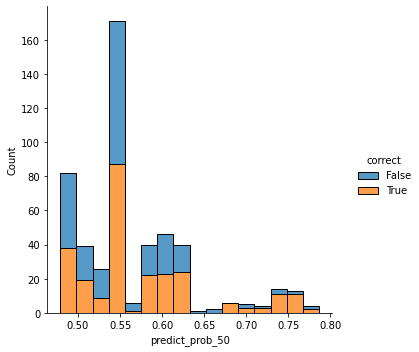

In [345]:
sns.displot(x='predict_prob_50',data=train_data, hue='correct',multiple='stack')

# Order and Position Analysis
- What is the fill rate of orders? Based on spread, levels in the book, recent price change, distance to bid/ask
- What is the holding time (assuming FIFO) of positions

In [212]:
toxicity_labels, reversion_labels = [], []
times = [1, 5, 10, 20, 30, 50, 100]
for t in times:
    toxicity_labels.append(f'toxicity_{t}')
    reversion_labels.append(f'fill_revert_{t}')
    
def order_analysis(orders):
    orders['px_bid_dist'] = orders['price'] - orders['bid']
    orders['px_ask_dist'] = orders['price'] - orders['ask']
    
    for t in [1, 5, 10, 20, 30, 50, 100]:
        orders[f'toxicity_{t}'] = orders['side']*(orders[f'fpx_{t}']+orders['mid_price']-orders['price'])
        orders[f'pnl_{t}'] = orders['fill_qty']*orders[f'toxicity_{t}']
        orders[f'fill_revert_{t}'] = np.sign(orders[f'pnl_{t}'])
        orders[f'spread_capture_{t}'] = orders[f'toxicity_{t}']/orders['spread']
    
    return

In [656]:
# file_name = "8fe34bcf-713b-4d7b-a87e-e4280b1465a8" # acceptable price, 1 less
# file_name = "93591b9b-f688-41ad-89a4-af25561035f7" # acceptable price
# file_name = "18d4470e-3b22-4a32-867e-0e7bd7861cc6" # acceptable price, 2 less
# file_name = "2d4db353-d908-4629-b604-7202a183a8e3" # version 6
file_name = "e6e6a924-84e8-44f6-a6ef-33e88117c48d" # version 7
file_name = "281ac96b-2019-4a66-8a0d-266a4ac59081" # Full run
file_name = "a2f10b5d-bb8e-4249-b892-2bb30fa11f97" # Full run
file_name = "5924da0f-4b5f-404b-b60d-a90a4d923ec3"
file_name = "3f494907-3d6f-40a1-af89-4ca5030d65a4"
file_name = "8a258c2d-e66a-4e2e-b5ad-095400639c6b"
# file_name = "58fa4f17-c902-453f-8ec5-60db308328d8"
file_name = "3dfc3128-1b83-4095-a07f-d3fab95f9be0"
file_name = "fd388f53-7317-4c19-94a7-ebf7dde94897"
file_name = "d9e47dbf-b059-4b15-abfe-266848b0134f" # no offset
file_name = "79529128-69f9-4b04-b0c1-3dd232b9fda0"

log_file = "logs/{}.log".format(file_name)
results_file = "logs/{}.csv".format(file_name)

dfs = load_data_from_log(log_file)
results = load_market_data(results_file)
symbols = ['BANANAS', 'PEARLS']

Symbols: ['BANANAS', 'PEARLS']


In [653]:
sym = symbols[1]
print(sym)
quote = dfs['order_depths'][sym].copy()
market_trades = dfs['market_trades'][sym].copy()
fills = dfs['own_trades'][sym].copy()
positions = dfs['positions'][sym].copy()

orders = dfs['orders'][sym].copy()
orders = orders.loc[orders.quantity != 0].copy()
quote = md_preprocess(quote)
orders = orders.merge(quote, how='left',on=['symbol','timestamp'], suffixes=('','_q'))
orders = orders.merge(positions, how='left',on=['symbol','timestamp'], suffixes=('','_p'))

order_analysis(orders)

PEARLS


In [657]:
for sym in symbols:
    quote = dfs['order_depths'][sym].copy()
    market_trades = dfs['market_trades'][sym].copy()
    fills = dfs['own_trades'][sym].copy()
    positions = dfs['positions'][sym].copy()
    
    orders = dfs['orders'][sym].copy()
    orders = orders.loc[orders.quantity != 0].copy()
    quote = md_preprocess(quote)
    orders = orders.merge(quote, how='left',on=['symbol','timestamp'], suffixes=('','_q'))
    orders = orders.merge(positions, how='left',on=['symbol','timestamp'], suffixes=('','_p'))
    
    order_analysis(orders)

    market_volume = market_trades['quantity'].sum()
    total_volume = orders.loc[orders.fill_qty > 0]['fill_qty'].sum()
    trade_count = len(orders.loc[orders.fill_qty > 0])
    pnl = results[sym]['profit_and_loss'].iloc[-1]
    print("""{}: PnL={} | Trades={} | MarketVol={} | Volume Filled={} | POV={:.2} | PnL/Share={:.4}""".format(sym, \
        pnl, trade_count, market_volume, total_volume,total_volume/market_volume, pnl/total_volume))

BANANAS: PnL=2173.76171875 | Trades=548 | MarketVol=393 | Volume Filled=1954.0 | POV=5.0 | PnL/Share=1.112
PEARLS: PnL=2655.0 | Trades=579 | MarketVol=257 | Volume Filled=1887.0 | POV=7.3 | PnL/Share=1.407


In [619]:
orders.loc[(orders['ask'] <= orders['fair_v1'])][['symbol','price','quantity','side','timestamp','fair_v1','position','fill_qty','bid','ask', 'bid_sz','ask_sz']]

,symbol,price,quantity,side,timestamp,fair_v1,position,fill_qty,bid,ask,bid_sz,ask_sz
26,BANANAS,4946,4,1,1300,4947.400000,-10.0,0.0,4944.0,4946.0,28,4
27,BANANAS,4946,34,1,1300,4947.400000,-10.0,0.0,4944.0,4946.0,28,4
28,BANANAS,4949,-10,-1,1300,4947.400000,-10.0,0.0,4944.0,4946.0,28,4
36,BANANAS,4948,2,1,1700,4948.482143,-11.0,0.0,4945.0,4948.0,27,2
37,BANANAS,4947,33,1,1700,4948.482143,-11.0,0.0,4945.0,4948.0,27,2
...,...,...,...,...,...,...,...,...,...,...,...,...
4040,BANANAS,4935,-1,-1,197700,4932.719298,-19.0,0.0,4929.0,4930.0,23,1
4050,BANANAS,4931,1,1,198300,4933.607143,-20.0,0.0,4930.0,4931.0,24,1
4051,BANANAS,4933,41,1,198300,4933.607143,-20.0,0.0,4930.0,4931.0,24,1
4071,BANANAS,4932,3,1,199900,4933.064516,-20.0,0.0,4931.0,4932.0,9,3


In [578]:
orders.loc[(orders['fill_qty']>0)][['price','quantity','side','timestamp','fair_v1','position','fill_qty']]

,price,quantity,side,timestamp,fair_v1,position,fill_qty
11,10003,-20,-1,500,10000.040816,NaN,1.0
35,10003,-19,-1,1700,10000.000000,-1.0,6.0
66,9998,27,1,3300,10000.000000,-7.0,9.0
67,10003,-13,-1,3300,10000.000000,-7.0,2.0
86,9998,20,1,4300,10000.000000,0.0,4.0
...,...,...,...,...,...,...,...
3902,9998,21,1,197000,9999.953488,-1.0,1.0
3910,9997,20,1,197400,9999.953488,0.0,9.0
3912,9998,11,1,197500,9999.818182,9.0,3.0
3916,9997,8,1,197700,10000.357143,12.0,1.0


In [575]:
orders.loc[(orders['fill_qty']>0) & (orders.fill_revert_50 == -1)].groupby('side')['position'].describe()

,count,mean,std,min,25%,50%,75%,max
side,,,,,,,,
-1,13.0,3.0000,3.439961,-1.0,0.00,4.0,6.00,8.0
1,16.0,-5.0625,4.479118,-12.0,-9.25,-5.0,-1.75,4.0


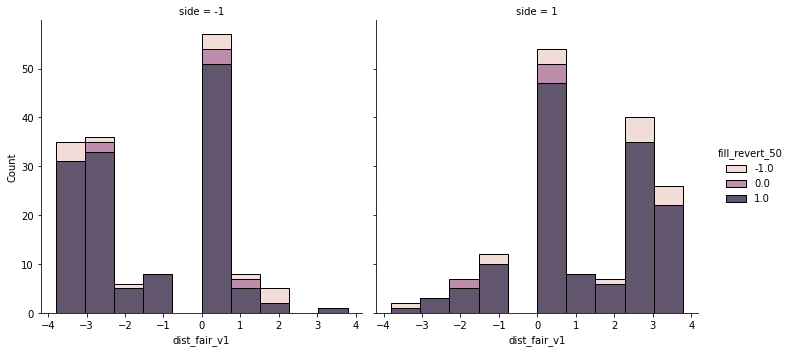

In [565]:
sns.displot(x='dist_fair_v1', data=orders.loc[(orders['fill_qty']>0)],col='side',hue='fill_revert_50', multiple='stack')

In [658]:
for sym in symbols:
    display(dfs['positions'][sym].describe())

,timestamp,position
count,1996.000000,1996.000000
mean,100149.799098,3.639279
std,57634.337397,9.903552
min,-1.000000,-20.000000
25%,50275.000000,-3.250000
50%,100150.000000,4.000000
75%,150025.000000,12.000000
max,199900.000000,20.000000


,timestamp,position
count,1997.000000,1997.000000
mean,100099.849274,1.101652
std,57663.117722,9.132688
min,-1.000000,-20.000000
25%,50200.000000,-6.000000
50%,100100.000000,1.000000
75%,150000.000000,8.000000
max,199900.000000,20.000000


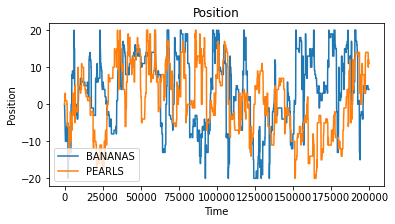

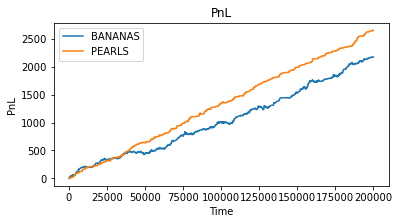

In [659]:
plot_position(dfs['positions'])
plot_pnl(results)

## Fill Rate

In [541]:
orders.groupby('side')[['fill_qty', 'quantity','active_qty','passive_qty']].agg(['sum','mean', 'count'])

fill_qty                 quantity                  active_qty            \
          sum      mean count      sum       mean count        sum      mean   
side                                                                           
-1      477.0  0.239698  1990   -40004 -20.102513  1990      167.0  0.083920   
 1      488.0  0.247465  1972    39996  20.281947  1972       99.0  0.050203   

           passive_qty                  
     count         sum      mean count  
side                                    
-1    1990       310.0  0.155779  1990  
 1    1972       389.0  0.197262  1972

In [381]:
orders.loc[orders.fill_qty > 0].groupby('side')[['fill_qty', 'quantity']].describe()

fill_qty                                               quantity  \
        count      mean       std  min  25%  50%  75%   max    count   
side                                                                   
-1       60.0  2.883333  2.565030  1.0  1.0  2.0  4.0  10.0     60.0   
 1       52.0  3.288462  2.739232  1.0  1.0  2.0  5.0  10.0     52.0   

                                                        
          mean       std   min   25%   50%   75%   max  
side                                                    
-1   -8.500000  2.977315 -10.0 -10.0 -10.0 -10.0  -1.0  
 1    8.326923  2.874643   1.0   7.0  10.0  10.0  10.0

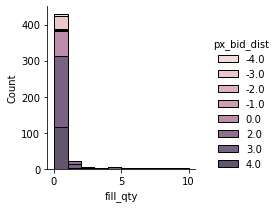

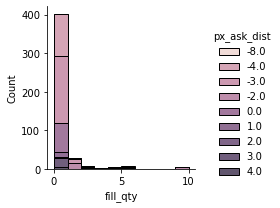

In [382]:
sns.displot(x='fill_qty',data=orders.loc[orders.side == 1], hue='px_bid_dist', height=3, multiple='stack')
sns.displot(x='fill_qty',data=orders.loc[orders.side == -1], hue='px_ask_dist', height=3, multiple='stack')

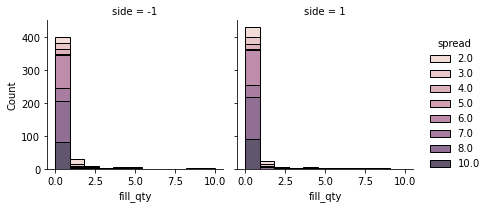

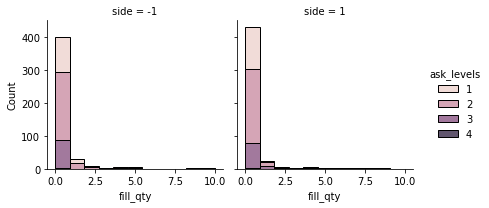

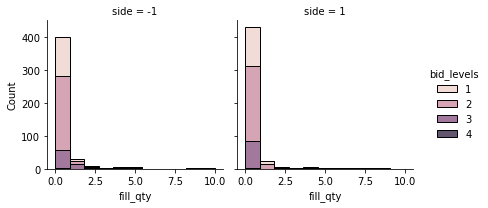

In [383]:
sns.displot(x='fill_qty',data=orders, hue='spread', col='side', height=3, multiple='stack')
sns.displot(x='fill_qty',data=orders, hue='ask_levels', col='side', height=3, multiple='stack')
sns.displot(x='fill_qty',data=orders, hue='bid_levels', col='side', height=3, multiple='stack')

In [302]:
orders.groupby(['side','bid_improve','bid_revert'])['fill_qty'].agg(['count','mean'])

count      mean
side bid_improve bid_revert                 
-1   False       False         223  0.152466
                 True          139  0.143885
     True        False         137  0.627737
 1   False       False         212  0.268868
                 True          133  0.210526
     True        False         122  0.090164

In [303]:
orders.groupby(['side', 'ask_improve','ask_revert'])['fill_qty'].agg(['count','mean'])

count      mean
side ask_improve ask_revert                 
-1   False       False         193  0.398964
                 True          154  0.285714
     True        False         152  0.125000
 1   False       False         176  0.136364
                 True          143  0.111888
     True        False         148  0.378378